<a href="https://colab.research.google.com/github/ankitbhutani1090/value_of_data/blob/main/notebooks/8_value_calcs_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import scipy
import copy
import matplotlib.pyplot as plt
import os
import math
import seaborn as sns
from scipy.special import erfinv  # for lognormal quantile grid
import statsmodels.api as sm


project_dir = '/content/drive/MyDrive/Data_GDP_OV'

In [ ]:
df = pd.read_csv(f'{project_dir}/Data/compustat_data.csv')
df.columns

Index(['gvkey', 'datadate', 'fyear', 'indfmt', 'consol', 'popsrc', 'datafmt',
       'tic', 'cusip', 'conm', 'curcd', 'fyr', 'am', 'at', 'capx', 'che',
       'dlc', 'dltt', 'emp', 'gdwl', 'ib', 'intan', 'ppegt', 'ppent', 'sale',
       'xlr', 'exchg', 'costat', 'naics', 'sic'],
      dtype='object')

In [ ]:
import pickle
import os


load_path = os.path.join(project_dir, 'Output/model_SMM4a_no_dep.pkl')

# Load the dictionary from the pickle file
with open(load_path, 'rb') as f:
    loaded_variables = pickle.load(f)


print(f"All variables loaded from: {load_path}")
print("Keys available in loaded_variables:", loaded_variables.keys())

# Example: Displaying a loaded DataFrame
# If you uncomment the line `df_panel = loaded_variables['df_panel']` above,
# you can then display it:
# display(df_panel.head())

All variables loaded from: /content/drive/MyDrive/Data_GDP_OV/Output/model_SMM4a_no_dep.pkl
Keys available in loaded_variables: dict_keys(['a_grid', 'omega_grid', 'k_grid', 'policies', 'values', 'df_panel', 'moments', 'targets', 'MU_LNA', 'SD_LNA', 'ALPHA', 'r', 'PHI', 'TAU', 'CHI', 'REV_M', 'w', 'GAMMA', 'PROD_MODE', 'BETA', 'PROD_FLOOR', 'DEN_FLOOR', 'RATIO_EPS', 'VFI_TOL', 'VFI_MAXIT'])


### Functions

In [ ]:
rho = 0.953
beta = 0.96                         # discount factor
def val_data_calcs(df, V_med, omega_grid, rev_med=720):
    df['tau_t'] = 0.0
    df['Omega_t'] = 0.0
    df['FV_t'] = 0.0
    df['SV_t'] = 0.0
    df['FV_precision_gain'] = 0.0
    df['SV_precision_gain'] = 0.0
    df['zeta_t'] = 0.0
    df['undep_data'] = 0.0
    df['val_dep'] = 0.0
    df['no_dep_Omega_t'] = 0.0
    df['disc_ratio'] = 0.0

    print(rev_med)
    def nearest_idx(grid, value):
        return np.abs(grid - value).argmin()

    # Period 1
    phi_1 = df.loc[df['fyear'] == 2003, 'phi_t'].values[0]
    fe0 = 1/phi_1
    Omega0 = phi_1
    fe1 = df.loc[df['fyear'] == 2003, 'sq_rel_err'].values[0]
    rev1 = df.loc[df['fyear'] == 2003, 'real_sale'].values[0]
    Omega1 = 1/fe1
    tau1 = Omega1 - Omega0

    FV_data_term = 1/Omega1 - 1/(Omega1 - tau1)
    SV_data_term = 1/Omega1 - 1/phi_1

    # Get nearest indices for prior and posterior
    idx_prior = nearest_idx(omega_grid, 1/phi_1)
    idx_post1  = nearest_idx(omega_grid, 1/(Omega1 - tau1))
    idx_post2  = nearest_idx(omega_grid, 1/Omega1)

    # Compute value differences
    FV1 = (V_med[idx_post2] - V_med[idx_post1]) * rev1/rev_med
    SV1 = (V_med[idx_post2] - V_med[idx_prior]) * rev1/rev_med

    #FV1 = V_med(1/Omega1) - V_med(1/(Omega1 - tau1))
    #SV1 = V_med(1/Omega1) - V_med(1/phi_1)

    df.loc[df['fyear'] == 2003, 'tau_t'] = tau1
    df.loc[df['fyear'] == 2003, 'Omega_t'] = Omega1
    df.loc[df['fyear'] == 2003, 'FV_t'] = FV1
    df.loc[df['fyear'] == 2003, 'SV_t'] = SV1
    df.loc[df['fyear'] == 2003, 'FV_precision_gain'] = -FV_data_term
    df.loc[df['fyear'] == 2003, 'SV_precision_gain'] = -SV_data_term
    zeta_t = 1 - 1/(rho**2 + Omega1/phi_1)
    disc_ratio = 1/(1 + rev1/FV1)
    df.loc[df['fyear'] == 2003, 'disc_ratio'] = disc_ratio

    df.loc[df['fyear'] == 2003, 'zeta_t'] = zeta_t
    df.loc[df['fyear'] == 2003, 'undep_data'] = 0.0
    df.loc[df['fyear'] == 2003, 'no_dep_Omega_t'] = Omega1

    phi_tm1 = phi_1
    fe_tm1 = fe1
    Omega_tm1 = Omega1
    zeta_tm1 = zeta_t

    # Period t
    for t in range(2004, 2023):

        phi_t = df.loc[df['fyear'] == t, 'phi_t'].values[0]
        fe_t = df.loc[df['fyear'] == t, 'sq_rel_err'].values[0]
        rev_t = df.loc[df['fyear'] == t, 'real_sale'].values[0]

        Delta_fe = fe_t - fe_tm1
        Omega_t = 1/(Delta_fe + 1/Omega_tm1)

        undep_data = (1 - zeta_tm1) * (Omega_tm1 - phi_tm1)
        tau_t = Omega_t - phi_t - undep_data

        FV_data_term = (1/Omega_t - 1/(Omega_t - tau_t))
        SV_data_term = (1/Omega_t - 1/phi_t)

        # Get nearest indices for prior and posterior
        idx_prior = nearest_idx(omega_grid, 1/phi_t)
        idx_post1  = nearest_idx(omega_grid, 1/(Omega_t - tau_t))
        idx_post2  = nearest_idx(omega_grid, 1/Omega_t)


        # Compute value differences
        FV_t = (V_med[idx_post2] - V_med[idx_post1]) * rev_t/rev_med
        SV_t = (V_med[idx_post2] - V_med[idx_prior]) * rev_t/rev_med

        no_dep_Omega_t = phi_t + Omega_tm1 - phi_tm1 + tau_t

        idx_ndO = nearest_idx(omega_grid, no_dep_Omega_t)
        val_dep = V_med[idx_ndO] - V_med[idx_post2]

        df.loc[df['fyear'] == t, 'tau_t'] = tau_t
        df.loc[df['fyear'] == t, 'Omega_t'] = Omega_t
        df.loc[df['fyear'] == t, 'FV_t'] = FV_t
        df.loc[df['fyear'] == t, 'SV_t'] = SV_t
        df.loc[df['fyear'] == t, 'FV_precision_gain'] = -FV_data_term
        df.loc[df['fyear'] == t, 'SV_precision_gain'] = -SV_data_term
        df.loc[df['fyear'] == t, 'undep_data'] = undep_data
        df.loc[df['fyear'] == t, 'no_dep_Omega_t'] = no_dep_Omega_t
        df.loc[df['fyear'] == t, 'val_dep'] = val_dep

        zeta_t = 1 - 1/(rho**2 + Omega_t/phi_t)
        disc_ratio = 1/(1 + rev_t/FV_t)

        df.loc[df['fyear'] == t, 'zeta_t'] = zeta_t
        df.loc[df['fyear'] == t, 'disc_ratio'] = disc_ratio

        phi_tm1 = phi_t
        fe_tm1 = fe_t
        Omega_tm1 = Omega_t
        zeta_tm1 = zeta_t

    return df


def plot_single_var_old(df, var1, lab1, ylab, title, filename):
    # Ensure fyear is sorted and unique
    years = sorted(df['fyear'].unique())
    alternate_years = years[::2]  # Take every second year

    # Set up the plot
    plt.figure(figsize=(10, 6))

    # Plot both variables
    plt.plot(df['fyear'], df[var1], label=lab1, marker='o')

    # Add labels and title
    plt.xlabel('Financial Year')
    plt.ylabel(ylab)
    plt.title(title)

    # Set alternate x-ticks
    plt.xticks(alternate_years)

    # Add legend and grid
    plt.legend()
    plt.tight_layout()

    # Save the figure
    plt.savefig(f'{project_dir}/Output/Figures/{filename}', dpi=300)

    # Show the plot
    plt.show()

def plot_single_var(df, var1, lab1, ylab, title, filename):
    years = sorted(df['fyear'].unique())
    alternate_years = years[::2]

    plt.figure(figsize=(10, 6))
    plt.plot(df['fyear'], df[var1], label=lab1, marker='o')

    # ---- NEW: set y-axis limits tightly around data ----
    ymin = df[var1].min()
    ymax = df[var1].max()

    # Compute a buffer based on the data range
    yrange = ymax - ymin
    buffer = yrange * 0.05 if yrange > 0 else 1  # fallback buffer if flat line

    # Set limits with symmetric padding
    plt.ylim(ymin - buffer, ymax + buffer)

    plt.xlabel('Financial Year')
    plt.ylabel(ylab)
    plt.title(title)
    plt.xticks(alternate_years)
    plt.legend()
    plt.tight_layout()

    plt.savefig(f'{project_dir}/Output/Figures/{filename}', dpi=300)
    plt.show()


def plot_output(df, var_list, lab_list, ylab, title, filename):
    # Ensure fyear is sorted and unique
    years = sorted(df['fyear'].unique())
    alternate_years = years[::2]  # Take every second year

    # Define a list of markers to cycle through
    markers = ['o', '|', 'x']

    # Set up the plot
    plt.figure(figsize=(10, 6))

    # Iterate over var_list, lab_list, and markers to make the plots
    for i, (var, lab) in enumerate(zip(var_list, lab_list)):
        # Use the modulo operator to cycle through markers
        marker = markers[i % len(markers)]
        plt.plot(df['fyear'], df[var], label=lab, marker=marker)

    plt.axhline(0, color='grey', linewidth=0.8)

    # Add labels and title
    plt.xlabel('Financial Year', fontsize=18) # Increased font size
    plt.ylabel(ylab, fontsize=18) # Increased font size
    plt.title(title, fontsize=18) # Increased font size

    # Set alternate x-ticks and increase font size
    plt.xticks(alternate_years, fontsize=18)
    plt.yticks(fontsize=18) # Increased font size

    # Add legend and grid, and increase legend font size
    plt.legend(fontsize=18)
    plt.tight_layout()

    # Save the figure
    plt.savefig(f'{project_dir}/Output/Figures/{filename}', dpi=300)

    # Show the plot
    plt.show()

def nearest_idx(grid, value):
    return np.abs(grid - value).argmin()

### Overall Data Median

In [ ]:
MU_LNA = loaded_variables['MU_LNA']
a_grid = loaded_variables['a_grid']
omega_grid = loaded_variables['omega_grid']
values = loaded_variables['values']
SD_LNA = loaded_variables['SD_LNA']

# Suppose your empirical median log A is mu_lnA (or just use np.median(A_data))
A_median = np.exp(MU_LNA)  # if mean of lnA is the median of A in lognormal
idx_a_med = np.argmin(np.abs(a_grid - A_median))
V_med = values[idx_a_med, :]
print(A_median)
print(idx_a_med)
#display(V_med)

42.52108200006278
25


In [ ]:
trimmed_ibes_comp = pd.read_csv(f'{project_dir}/Output/capped_ibes_compustat.csv')
median_rev_2022 = trimmed_ibes_comp[trimmed_ibes_comp['fyear']==2022]['real_sale'].median()
median_rev_sample = trimmed_ibes_comp['real_sale'].median()
median_sq_rel_err_post = trimmed_ibes_comp['sq_rel_err'].median()
print(trimmed_ibes_comp['sq_rel_err'].mean())
print(median_sq_rel_err_post)
print(median_rev_2022)
print(median_rev_sample)

prior_df = pd.read_csv(f'{project_dir}/Output/prior_sq_rel_err.csv')
prior_df = prior_df[['gvkey', 'fyear', 'sq_rel_err']].rename(columns={'sq_rel_err': 'sq_rel_err_prior'})
print(prior_df['sq_rel_err_prior'].median())
result_df = prior_df.groupby('fyear')['sq_rel_err_prior'].median().reset_index()

df = trimmed_ibes_comp[['fyear', 'real_sale', 'sq_rel_err', 'emp']].groupby('fyear').median().reset_index()
df = copy.deepcopy(df[df['fyear']>2002])
df = df.merge(result_df, on='fyear', how='left')
df['phi_t'] = 1/df['sq_rel_err_prior']
tot_emp_sample = trimmed_ibes_comp.groupby('fyear')['emp'].sum().reset_index().rename(columns={'emp': 'tot_emp_sample'})
df = df.merge(tot_emp_sample, on='fyear', how='left')

df = val_data_calcs(df, V_med, omega_grid)
df['value_data_per_emp'] = df['FV_t']/df['emp'] * 1000
df['data_pcnt_of_revenue'] = df['FV_t']/df['real_sale'] * 100
df_post_2003 = df[df['fyear']>2003]
df_emp = pd.read_csv(f'{project_dir}/Data/employment_CE16OV.csv')
df_emp['total_emp_mil'] = df_emp['total_emp']/1000

df_post_2003 = pd.merge(df_post_2003, df_emp, on='fyear', how='left')
df_post_2003['val_data_econ_using_val_per_emp_bil'] = df_post_2003['value_data_per_emp'] * df_post_2003['total_emp_mil']/1e3
df_post_2003['val_data_sample_using_val_per_emp_bil'] = df_post_2003['value_data_per_emp'] * df_post_2003['tot_emp_sample']/1e6
df_post_2003['missing_GDP_econ'] = df_post_2003['val_data_econ_using_val_per_emp_bil'] * 2
df_post_2003['missing_GDP_sample'] = df_post_2003['val_data_sample_using_val_per_emp_bil'] * 2
df_post_2003

0.02050996221396666
0.0022903344370373
866.9224127545078
719.6054845966835
0.0070004864
720


,fyear,real_sale,sq_rel_err,emp,sq_rel_err_prior,phi_t,tot_emp_sample,tau_t,Omega_t,FV_t,...,no_dep_Omega_t,disc_ratio,value_data_per_emp,data_pcnt_of_revenue,total_emp,total_emp_mil,val_data_econ_using_val_per_emp_bil,val_data_sample_using_val_per_emp_bil,missing_GDP_econ,missing_GDP_sample
0,2004,376.497653,0.003345,1.8260,0.006494,153.980124,5866.948,94.665074,298.939120,2.855239,...,471.301379,0.007527,1563.657757,0.758368,139240,139.240,217.723706,9.173899,435.447412,18.347797
1,2005,504.782705,0.002439,2.7795,0.006856,145.865865,7629.016,213.348236,410.083641,5.754055,...,504.173098,0.011271,2070.176282,1.139907,141710,141.710,293.364681,15.793408,586.729362,31.586816
2,2006,489.210843,0.002999,2.5255,0.006610,151.282024,10920.572,111.126394,333.442646,3.304622,...,526.626194,0.006710,1308.502034,0.675501,144418,144.418,188.971247,14.289591,377.942493,28.579181
3,2007,471.128924,0.003155,2.2770,0.007006,142.733996,8948.305,115.690616,316.953464,3.975155,...,440.585235,0.008367,1745.786240,0.843751,146050,146.050,254.972080,15.621828,509.944161,31.243655
4,2008,599.778838,0.002577,2.9550,0.010279,97.283802,13078.998,235.143955,388.110323,11.012652,...,506.647226,0.018030,3726.785924,1.836119,145373,145.373,541.774050,48.742626,1083.548100,97.485251
5,2009,672.768822,0.004153,3.6670,0.010223,97.821190,10396.657,83.569494,240.771222,6.430672,...,472.217204,0.009468,1753.660295,0.955852,139894,139.894,245.326553,18.232205,490.653107,36.464409
6,2010,641.558478,0.002607,3.4000,0.006391,156.463800,9069.354,184.633769,383.521653,6.878563,...,484.047603,0.010608,2023.106720,1.072165,139077,139.077,281.367613,18.348271,562.735227,36.696542
7,2011,661.159354,0.002722,3.4285,0.006675,149.823592,9536.711,150.031443,367.443976,5.767769,...,526.912888,0.008648,1682.300910,0.872372,139885,139.885,235.328663,16.043618,470.657326,32.087235
8,2012,639.487108,0.002004,3.2000,0.006261,159.721760,8723.965,274.482250,498.958109,7.200912,...,651.824394,0.011135,2250.285018,1.126045,142475,142.475,320.609358,19.631408,641.218716,39.262815
9,2013,703.107891,0.001182,3.7915,0.004264,234.505088,10294.063,527.107318,845.745699,6.309675,...,1100.848756,0.008894,1664.163133,0.897398,143941,143.941,239.541306,17.131000,479.082611,34.262000


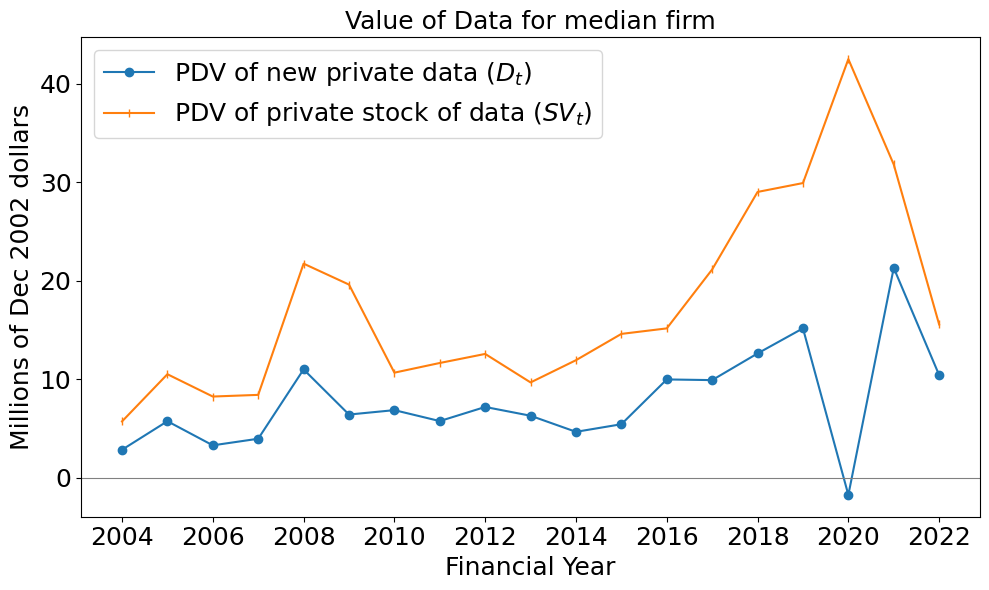

In [ ]:
method = 'mult_with_dep'
plot_output(df_post_2003, ['FV_t', 'SV_t'],
 [r'PDV of new private data ($D_t$)', r'PDV of private stock of data ($SV_t$)'],
            'Millions of Dec 2002 dollars', 'Value of Data for median firm', f'value_of_data_{method}_model.png')

/tmp/ipython-input-3797578500.py:169: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


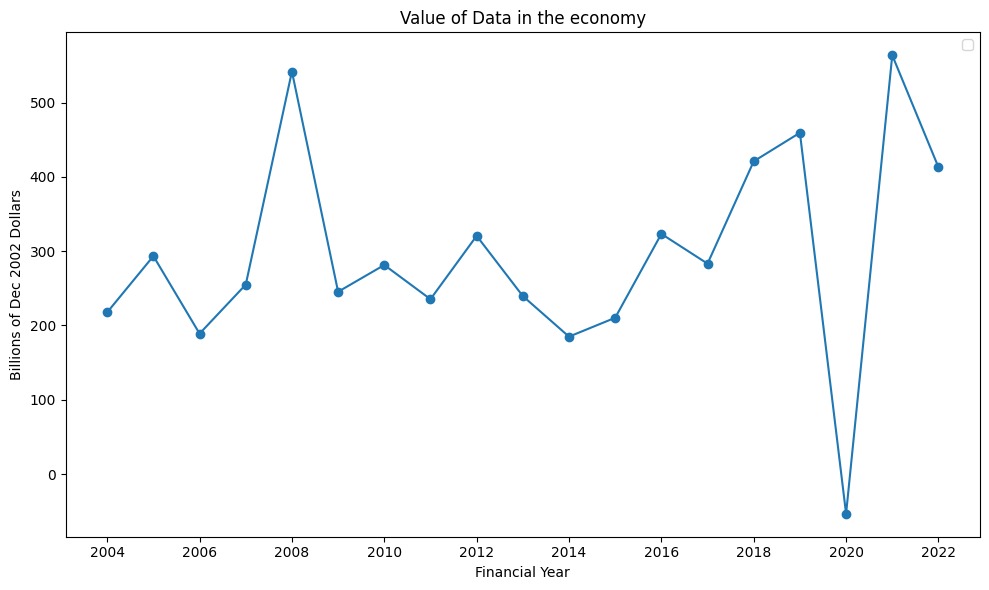

In [ ]:
plot_single_var(df_post_2003, 'val_data_econ_using_val_per_emp_bil', r'_',
            'Billions of Dec 2002 Dollars', 'Value of Data in the economy', f'real_val_data_econ_using_val_per_emp.png')

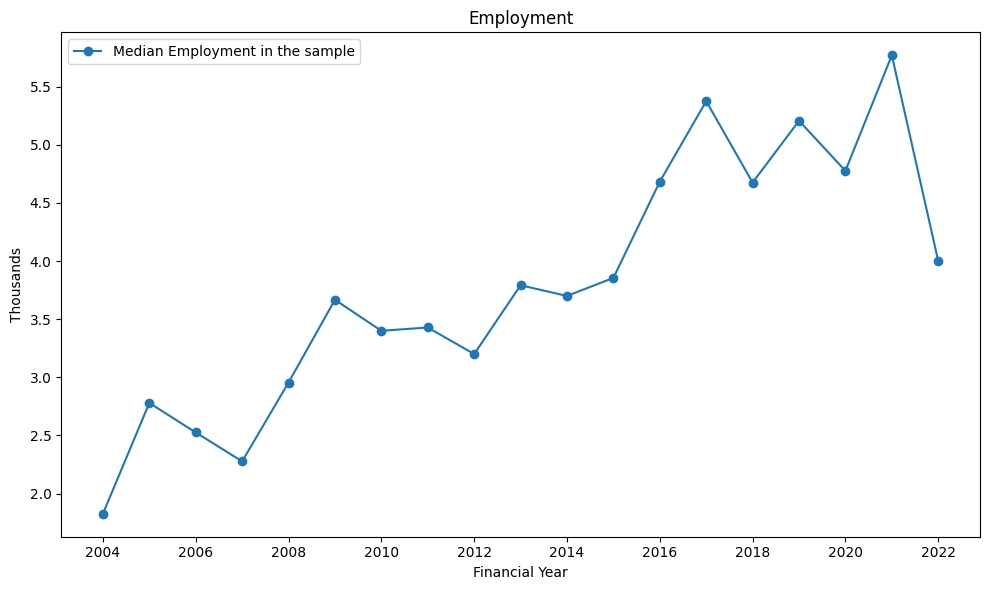

In [ ]:
plot_single_var(df_post_2003, 'emp', r'Median Employment in the sample',
            'Thousands', 'Employment', f'median_emp_sample.png')

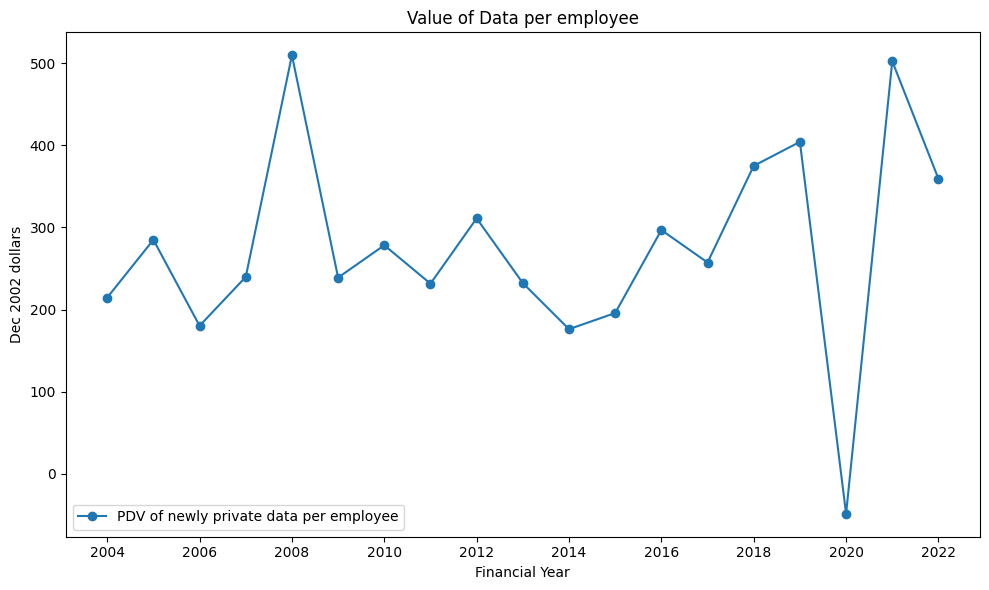

In [ ]:
plot_single_var(df_post_2003, 'value_data_per_emp', r'PDV of newly private data per employee',
            'Dec 2002 dollars', 'Value of Data per employee', f'value_of_data_per_emp.png')

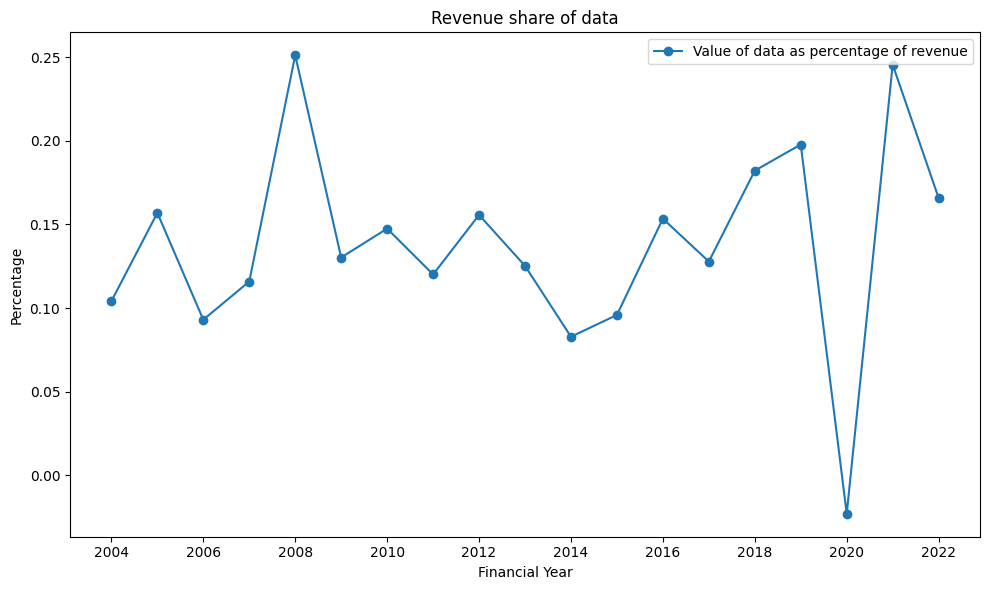

In [ ]:
plot_single_var(df_post_2003, 'data_pcnt_of_revenue', r'Value of data as percentage of revenue',
            'Percentage', 'Revenue share of data', f'data_pcnt_of_revenue.png')

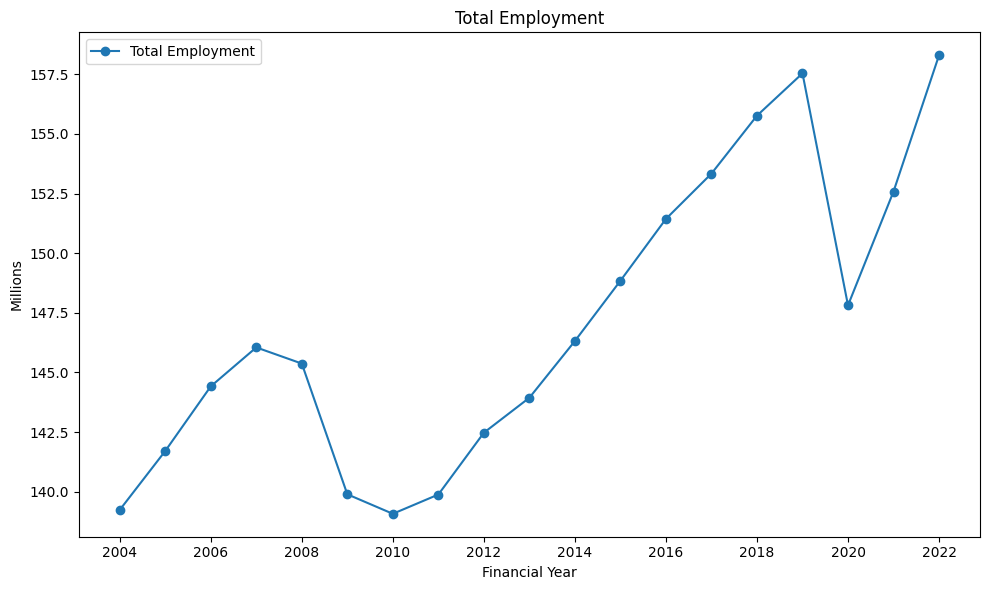

In [ ]:
plot_single_var(df_post_2003, 'total_emp_mil', 'Total Employment', 'Millions', 'Total Employment', f'total_emp_econ.png')

In [ ]:
rgdp = pd.read_csv(f'{project_dir}/Data/GDPC1.csv')
rgdp['observation_date'] = pd.to_datetime(rgdp['observation_date'])  # Ensure CPI dataset is also in datetime format
rgdp['fyear'] = rgdp['observation_date'].dt.year
rgdp = rgdp.merge(df_post_2003[['fyear', 'missing_GDP_econ', 'missing_GDP_sample']], on='fyear', how='inner')

# Get CPI numbers
cpi_data = pd.read_csv(f'{project_dir}/Data/CPIAUCSL.csv')
cpi_data['observation_date'] = pd.to_datetime(cpi_data['observation_date'])  # Ensure CPI dataset is also in datetime format
cpi_dec_2002 = cpi_data.loc[cpi_data['observation_date'] == '2002-12-01', 'CPIAUCSL'].values[0]
cpi_jun_2017 = cpi_data.loc[cpi_data['observation_date'] == '2017-06-01', 'CPIAUCSL'].values[0]

for col in ['missing_GDP_econ', 'missing_GDP_sample']:
    rgdp[col + '_Jun2017'] = rgdp[col] * cpi_jun_2017 / cpi_dec_2002
    rgdp[col + '_share'] = rgdp[col + '_Jun2017']/rgdp['GDPC1'] * 100

rgdp

,observation_date,GDPC1,fyear,missing_GDP_econ,missing_GDP_sample,missing_GDP_econ_Jun2017,missing_GDP_econ_share,missing_GDP_sample_Jun2017,missing_GDP_sample_share
0,2004-01-01,15449.757,2004,435.447412,18.347797,584.819288,3.785298,24.641657,0.159495
1,2005-01-01,15987.958,2005,586.729362,31.586816,787.995606,4.928682,42.422067,0.265338
2,2006-01-01,16433.148,2006,377.942493,28.579181,507.588410,3.088808,38.382721,0.233569
3,2007-01-01,16762.446,2007,509.944161,31.243655,684.870716,4.085745,41.961192,0.250329
4,2008-01-01,16781.485,2008,1083.548100,97.485251,1455.238475,8.671691,130.925695,0.780179
5,2009-01-01,16349.111,2009,490.653107,36.464409,658.962236,4.030569,48.972825,0.299544
6,2010-01-01,16789.751,2010,562.735227,36.696542,755.770743,4.501381,49.284586,0.293540
7,2011-01-01,17052.411,2011,470.657326,32.087235,632.107286,3.706850,43.094145,0.252716
8,2012-01-01,17442.759,2012,641.218716,39.262815,861.176487,4.937158,52.731171,0.302310
9,2013-01-01,17812.167,2013,479.082611,34.262000,643.422704,3.612265,46.014922,0.258334


In [ ]:
rgdp['missing_GDP_econ_share'].median()

4.085744501265694

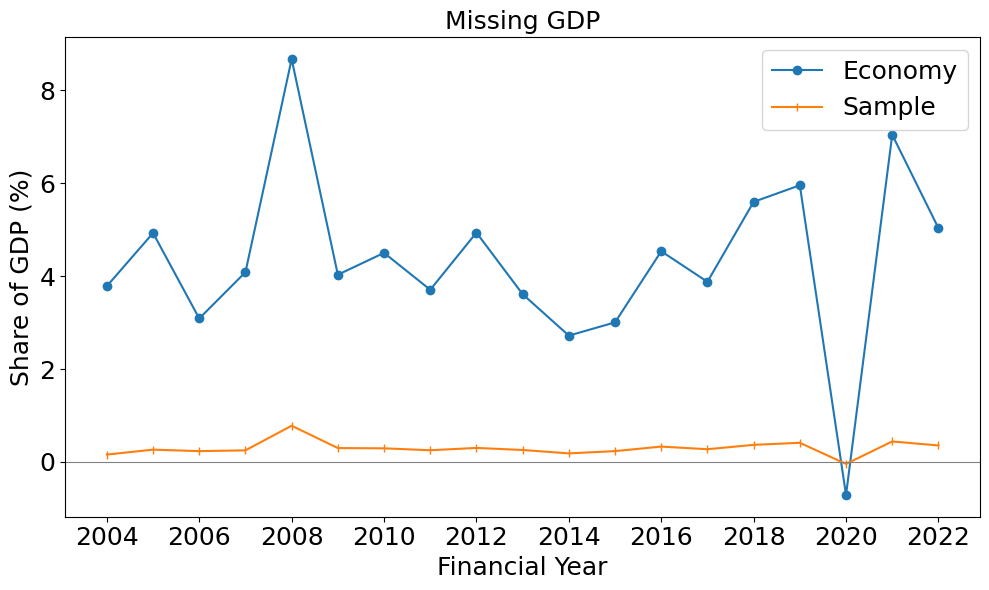

In [ ]:
plot_output(rgdp, ['missing_GDP_econ_share', 'missing_GDP_sample_share'],
 [r'Economy', 'Sample'], 'Share of GDP (%)', 'Missing GDP', f'missing_GDP_using_median_val_per_emp_no_dep.png')
#plot_single_var(rgdp, 'missing_GDP_econ_share', r'Economy',
#            'Share of GDP (%)', 'Missing GDP', f'missing_GDP_econ_using_median_val_per_emp.png')

In [ ]:
rgdp['missing_GDP_econ_share'].mean()

np.float64(1.5293506121645586)

### By Revenue Quintiles

In [ ]:
revenue_percentiles = trimmed_ibes_comp['real_sale'].quantile([0.1, 0.3, 0.5, 0.7, 0.9])
revenue_array = revenue_percentiles.values
print(revenue_array)

def A_at_percentiles(mu, sigma, ps=(0.10, 0.30, 0.50, 0.70, 0.90)):
    z = scipy.stats.norm.ppf(ps)
    return np.exp(mu + sigma*z)

As = A_at_percentiles(mu=MU_LNA, sigma=SD_LNA)  # or sigma=1.19
idxs = [np.argmin(np.abs(a_grid - A)) for A in As]
V_rows = [values[i, :] for i in idxs]  # value functions at those percentile A's

[  81.86931362  293.26601669  719.6054846  1809.80294295 6817.63576686]


In [ ]:
# Create a new dataframe by merging trimmed_ibes_comp with prior_df
revenue_cutoffs = trimmed_ibes_comp['real_sale'].quantile([0.2, 0.4, 0.6, 0.8])
revenue_cutoffs = revenue_cutoffs.values
print(revenue_cutoffs)

merged_df = trimmed_ibes_comp.merge(prior_df, on=['gvkey', 'fyear'], how='left')
print(merged_df['sq_rel_err'].describe())
print(merged_df['sq_rel_err_prior'].describe())

# Fixed cutoffs using revenue_array
bins = [-np.inf] + list(revenue_cutoffs) + [np.inf]

merged_df['real_sale_quintile'] = pd.cut(
    merged_df['real_sale'],
    bins=bins,
    labels=[0, 1, 2, 3, 4],
    include_lowest=True
)

merged_df = merged_df[merged_df['fyear']>2002]
df_emp = pd.read_csv(f'{project_dir}/Data/employment_CE16OV.csv')
df_emp['total_emp_mil'] = df_emp['total_emp']/1000
make_plots = False
df_list = []
for i in range(5):
    df_t = copy.deepcopy(merged_df[merged_df['real_sale_quintile'] == i])
    # Get the number of firms and total emp by firms in each year
    df_t['N_t'] = 1
    df_t['emp_sum'] = df_t['emp']
    df_t['emp_median'] = df_t['emp']
    df_t = df_t.groupby('fyear').agg({'real_sale': 'median', 'sq_rel_err': 'median', 'sq_rel_err_prior': 'median', 'N_t': 'sum', 'emp_sum': 'sum', 'emp_median':'median'}).reset_index()
    #df_t = df_t[['fyear', 'real_sale', 'sq_rel_err', 'sq_rel_err_prior']].groupby('fyear').median().reset_index()
    df_t['phi_t'] = 1/df_t['sq_rel_err_prior']
    df_t = val_data_calcs(df_t, V_rows[i], omega_grid, revenue_array[i])
    df_t['value_data_per_emp'] = df_t['FV_t']/df_t['emp_median'] * 1000
    df_t['data_pcnt_of_revenue'] = df_t['FV_t']/df_t['real_sale'] * 100

    df_t = pd.merge(df_t, df_emp, on='fyear', how='left')
    #df_t['val_data_econ_using_val_per_emp_bil'] = df_t['value_data_per_emp'] * df_t['total_emp_mil']/1e3

    #df_t['missing_GDP_sample'] = df_t['N_t'] * df_t['FV_t'] * 2/1000
    df_t['missing_GDP_sample'] = df_t['value_data_per_emp'] * df_t['emp_sum'] * 2/1e6
    df_list.append(df_t)
    """
    if make_plots:
        title_str = f'Components of Data Stock over Time (Revenue Quintile Q{i+1})'
        data_stock_decomp(df_t, f'stacked_data_components_real_sale_q{i+1}.png', title_str, True)

        plot_output(df_t, ['FV_t', 'SV_t', 'val_dep'],
        [r'PDV of new private data ($FV_t$)', r'PDV of private stock of data ($SV_t$)',
          r'PDV of Depreciation $(DEP_t)$'],
                'Millions of Dec 2002 dollars', f'Value of Data (Revenue Quintile Q{i+1})', f'value_of_data_real_sale_q{i+1}.png')

        plot_output(df_t, ['FV_precision_gain', 'SV_precision_gain'], [r'Gain in precision (Flow)', r'Gain in precision (Stock)'], 'Precision',
                    f'Gain in precision (Revenue Quintile Q{i+1})', f'precision_gain_real_sale_q{i+1}.png')

        #plot_single_var(df_t, 'disc_ratio', 'Discount Ratio (FV/PQ)', '', f'Discount ratio (Revenue Quintile Q{i+1})', f'disc_ratio_q{i+1}.png')
    """

[ 173.91210595  464.46537265 1149.60686747 3156.09558807]
count    12525.000000
mean         0.020510
std          0.064805
min          0.000000
25%          0.000410
50%          0.002290
75%          0.010453
max          0.490651
Name: sq_rel_err, dtype: float64
count    1.251500e+04
mean     5.052594e-02
std      1.685734e-01
min      2.158635e-09
25%      1.401042e-03
50%      7.000486e-03
75%      3.013551e-02
max      3.944323e+00
Name: sq_rel_err_prior, dtype: float64
81.86931361880407
293.2660166947513
719.6054845966835
1809.8029429481464


/tmp/ipython-input-3797578500.py:105: RuntimeWarning: divide by zero encountered in scalar divide
  disc_ratio = 1/(1 + rev_t/FV_t)
/tmp/ipython-input-3797578500.py:105: RuntimeWarning: divide by zero encountered in scalar divide
  disc_ratio = 1/(1 + rev_t/FV_t)


6817.635766862337


In [ ]:
df_list[4]

,fyear,real_sale,sq_rel_err,sq_rel_err_prior,N_t,emp_sum,emp_median,phi_t,tau_t,Omega_t,...,zeta_t,undep_data,val_dep,no_dep_Omega_t,disc_ratio,value_data_per_emp,data_pcnt_of_revenue,total_emp,total_emp_mil,missing_GDP_sample
0,2003,5793.294663,0.000891,0.008961,29,1723.837,40.0000,111.595042,1010.429380,1122.024422,...,0.908781,0.000000,0.000000,1122.024422,0.009971,1458.658250,1.007136,137729,137.729,5.028978
1,2004,6626.077972,0.002121,0.002639,86,4371.542,34.5000,378.920372,0.395082,471.485731,...,0.535423,92.170277,-3319.832989,1389.744834,0.000000,0.000000,0.000000,139240,139.240,0.000000
2,2005,7251.871556,0.001250,0.004005,109,5340.069,33.5000,249.702349,507.542960,800.249038,...,0.756870,43.003729,-3327.175798,849.810668,0.002589,562.008541,0.259620,141710,141.710,6.002329
3,2006,7023.942359,0.001346,0.003880,114,8255.791,34.4770,257.741053,351.294846,742.890482,...,0.736184,133.854584,-3326.353317,1159.582587,0.001626,331.769555,0.162849,144418,144.418,5.478040
4,2007,6128.205487,0.002262,0.002475,119,6308.974,31.5720,404.111462,-89.995631,442.105956,...,0.500557,127.990124,-3318.421785,799.265261,-0.000399,-77.373583,-0.039862,146050,146.050,-0.976296
5,2008,7688.648435,0.001281,0.004432,131,10278.294,39.8000,225.627325,536.074908,780.678332,...,0.771075,18.976099,-3326.353317,799.696726,0.003531,684.471634,0.354314,145373,145.373,14.070401
6,2009,6743.687073,0.002600,0.008499,108,8039.889,32.5020,117.666094,139.871406,384.602533,...,0.760582,127.065033,-3315.250866,812.588507,0.001911,397.262106,0.191465,139894,139.894,6.387886
7,2010,6451.080039,0.001084,0.003777,120,6725.645,32.6140,264.749930,593.705540,922.364762,...,0.772319,63.909292,-3328.642143,1125.391908,0.002501,495.864780,0.250689,139077,139.077,6.670021
8,2011,6757.564494,0.001673,0.003223,130,7002.227,31.9500,310.248117,137.633909,597.608144,...,0.647196,149.726118,-3323.468639,1105.496858,0.000533,112.789215,0.053327,139885,139.885,1.579551
9,2012,6372.123770,0.000654,0.005384,127,6291.161,29.5550,185.732025,1241.810020,1528.923794,...,0.890592,101.381748,-3331.899126,1714.902072,0.003605,780.006260,0.361780,142475,142.475,9.814290


In [ ]:
val_data_per_emp = df_list[0]
val_data_per_emp = val_data_per_emp[['fyear', 'value_data_per_emp']].rename(columns = {'value_data_per_emp': 'Q1'})

for i in range(1,5):
    df_t = df_list[i]
    df_t = df_t[['fyear', 'value_data_per_emp']].rename(columns = {'value_data_per_emp': f'Q{i+1}'})
    val_data_per_emp = val_data_per_emp.merge(df_t, on='fyear', how='left')

val_data_per_emp = val_data_per_emp[val_data_per_emp['fyear']>2003]
val_data_per_emp

,fyear,Q1,Q2,Q3,Q4,Q5
1,2004,800.568059,777.352882,691.525003,507.269106,0.000000
2,2005,3339.674901,953.812128,437.743738,216.664759,562.008541
3,2006,3362.493286,1023.267314,58.453251,619.813817,331.769555
4,2007,2980.304753,1231.644541,624.915678,161.895358,-77.373583
5,2008,5263.370611,1464.281205,1108.727352,955.692831,684.471634
6,2009,3251.749506,1523.833570,96.191754,187.744551,397.262106
7,2010,3273.424182,1085.539075,351.793729,640.385894,495.864780
8,2011,2215.062898,843.714821,728.602667,166.575848,112.789215
9,2012,2194.857454,1144.227760,980.799126,343.991537,780.006260
10,2013,2743.512680,1185.884954,488.446237,437.358830,301.154602


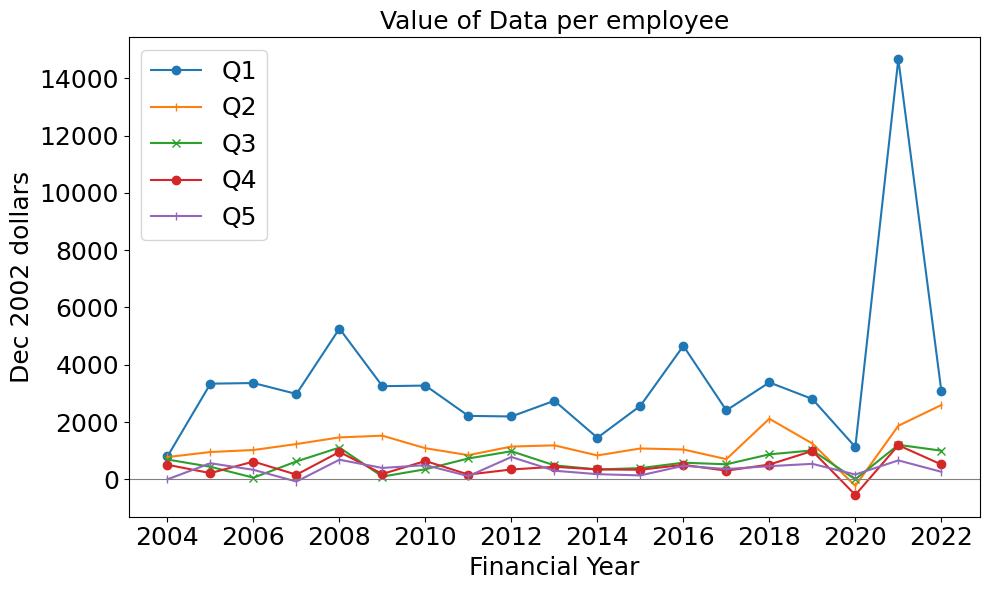

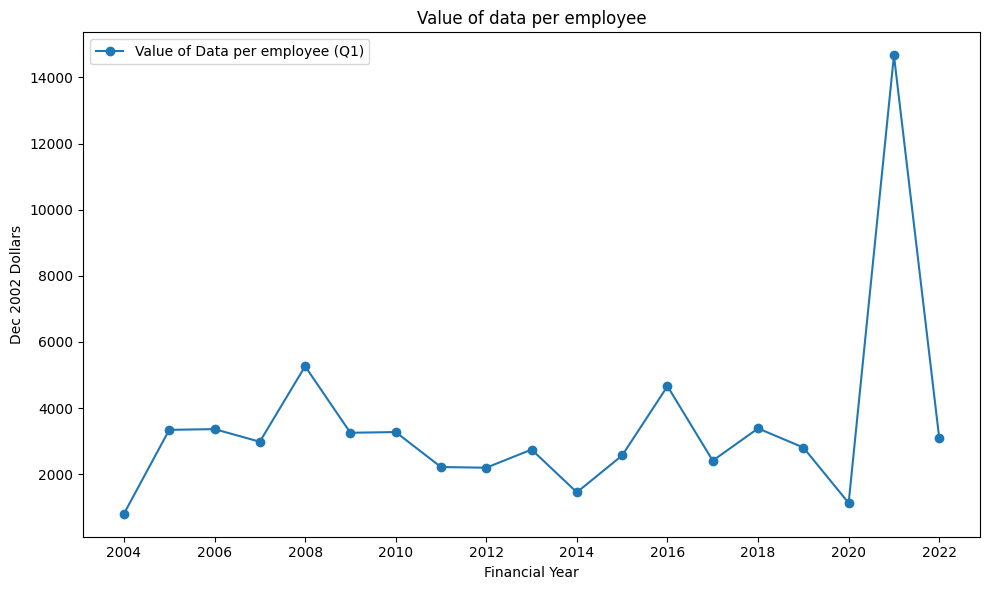

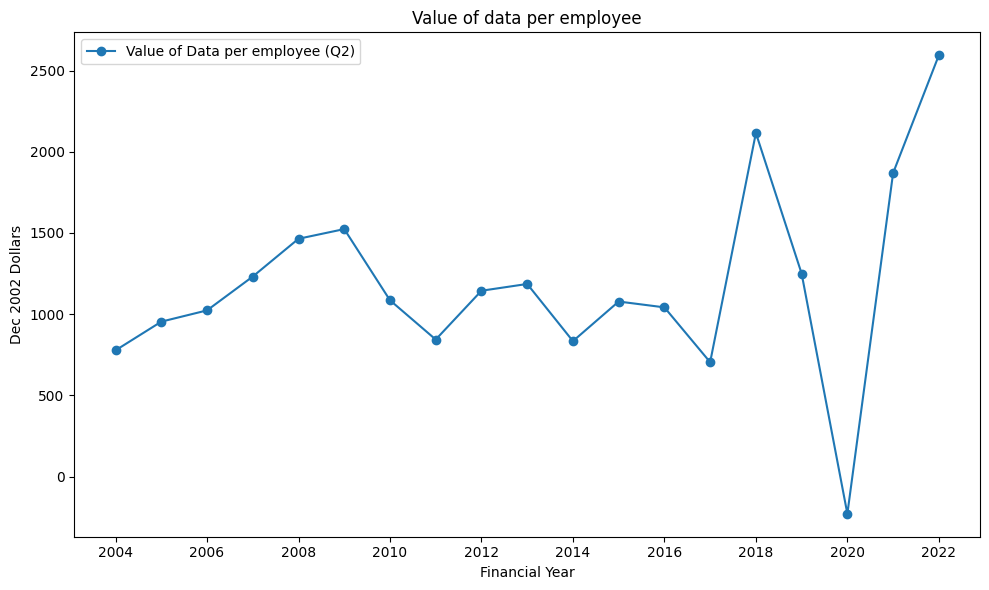

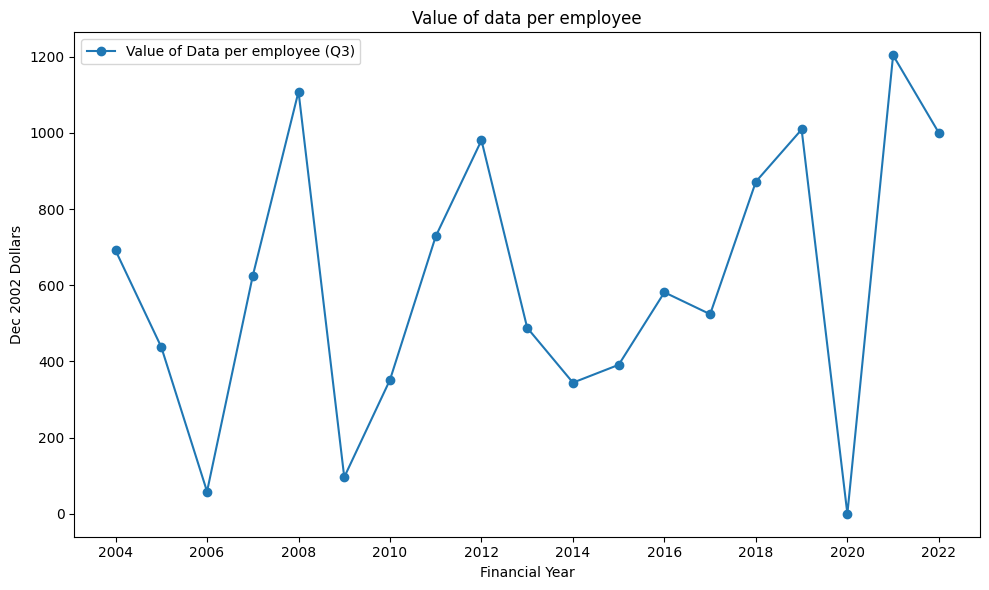

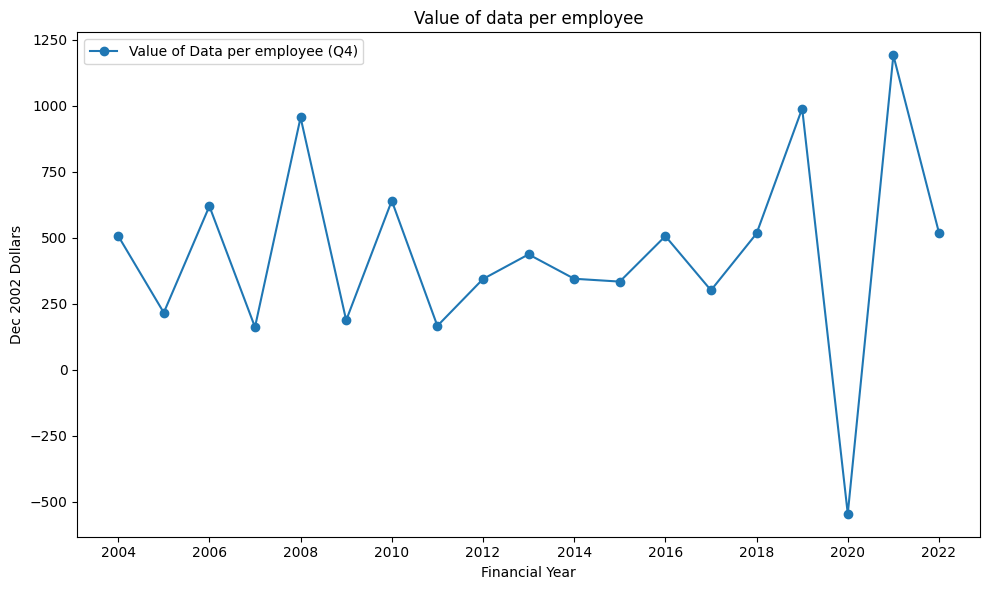

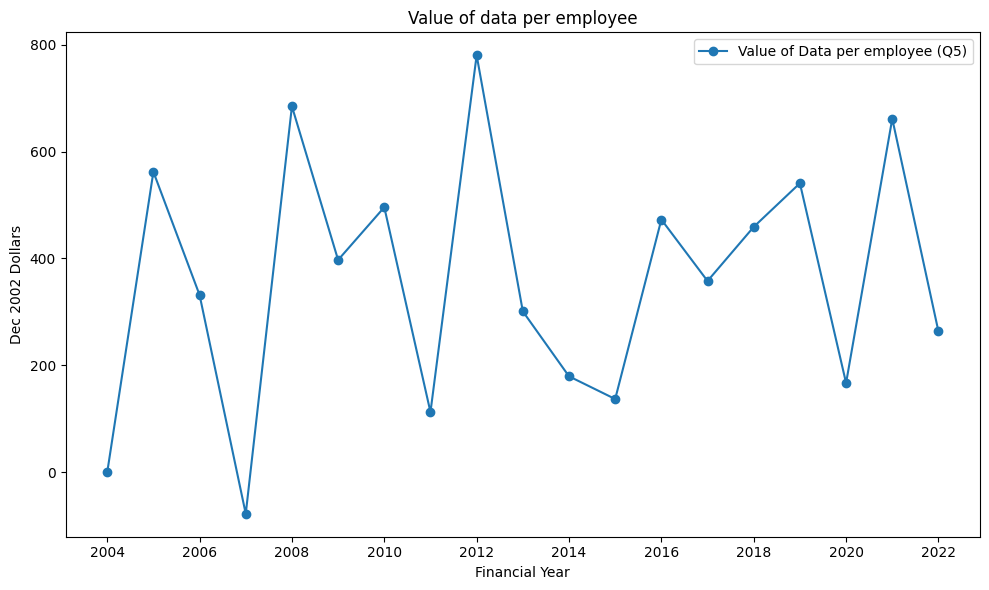

In [ ]:
plot_output(val_data_per_emp, ['Q1', 'Q2', 'Q3', 'Q4', 'Q5'],
 ['Q1', 'Q2', 'Q3', 'Q4', 'Q5'], 'Dec 2002 dollars', 'Value of Data per employee', f'val_data_per_emp_by_quintile.png')


for i in range(5):
  plot_single_var(val_data_per_emp, f'Q{i+1}', f'Value of Data per employee (Q{i+1})', 'Dec 2002 Dollars', 'Value of data per employee', f'val_data_per_emp_Q{i+1}.png')

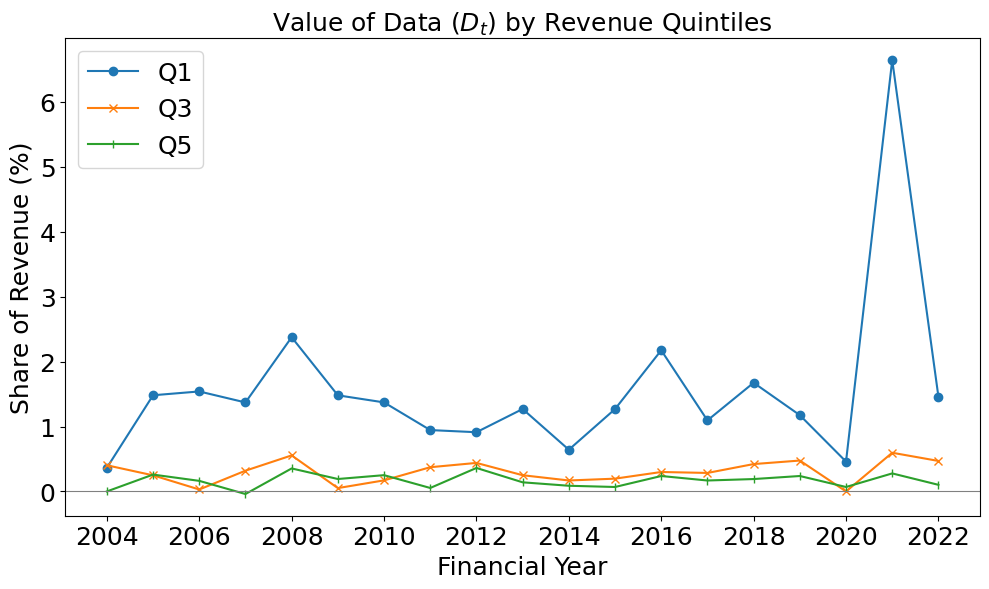

In [ ]:
method='using_val_data_per_emp'
# Ensure fyear is sorted and unique
years = sorted(df_t['fyear'].unique())
alternate_years = years[::2]  # Take every second year

# Set up the plot
plt.figure(figsize=(10, 6))

# Define a list of markers to cycle through
markers = ['o', '|', 'x']

# Iterate over var_list and lab_list to make the plots
for i in [0,2,4]:
    df_t = df_list[i]
    df_t = copy.deepcopy(df_t[df_t['fyear']>2003])
    df_t['data_share_rev'] = df_t['FV_t']/df_t['real_sale'] * 100
    var = 'data_share_rev'
    lab = r'Q{}'.format(i+1)
    marker = markers[i % len(markers)]
    plt.plot(df_t['fyear'], df_t[var], label=lab, marker=marker)

plt.axhline(0, color='grey', linewidth=0.8)

# Add labels and title
plt.xlabel('Financial Year', fontsize=18)
plt.ylabel('Share of Revenue (%)', fontsize=18)
plt.title(r"Value of Data $(D_t)$ by Revenue Quintiles", fontsize=18)

# Set alternate x-ticks and increase font size
plt.xticks(alternate_years, fontsize=18)
plt.yticks(fontsize=18) # Increased font size

# Add legend and grid
plt.legend(fontsize=18)
plt.tight_layout()

# Save the figure
plt.savefig(f'{project_dir}/Output/Figures/Dt_rev_alt_quintiles_{method}_model.png', dpi=300)

# Show the plot
plt.show()

In [ ]:
df_t = df_list[0]
col_list = ['fyear', 'N_t', 'FV_t', 'emp_sum', 'value_data_per_emp', 'missing_GDP_sample']
# Create a dictionary to rename all columns in col_list appending _q1
col_dict = {col: col + '_q1' for col in col_list[1:]}
sample_mgdp = copy.deepcopy(df_t[col_list].rename(columns=col_dict))

for i in range(1,5):
    df_t = df_list[i]
    col_dict = {col: col + f'_q{i+1}' for col in col_list[1:]}
    sample_mgdp = sample_mgdp.merge(df_t[col_list].rename(columns=col_dict), on='fyear', how='left')

sample_mgdp['missing_GDP_sample_total'] = (sample_mgdp['missing_GDP_sample_q1'] + sample_mgdp['missing_GDP_sample_q2'] +
                                       sample_mgdp['missing_GDP_sample_q3'] + sample_mgdp['missing_GDP_sample_q4'] + sample_mgdp['missing_GDP_sample_q5'])
sample_mgdp

,fyear,N_t_q1,FV_t_q1,emp_sum_q1,value_data_per_emp_q1,missing_GDP_sample_q1,N_t_q2,FV_t_q2,emp_sum_q2,value_data_per_emp_q2,...,FV_t_q4,emp_sum_q4,value_data_per_emp_q4,missing_GDP_sample_q4,N_t_q5,FV_t_q5,emp_sum_q5,value_data_per_emp_q5,missing_GDP_sample_q5,missing_GDP_sample_total
0,2003,69,3.389248,38.401,8712.718684,0.669154,66,3.601458,139.195,2709.900571,...,14.231285,366.259,2092.835990,1.533040,29,58.346330,1723.837,1458.658250,5.028978,8.853344
1,2004,181,0.272193,88.562,800.568059,0.141800,125,0.970914,257.277,777.352882,...,3.652338,635.264,507.269106,0.644500,86,0.000000,4371.542,0.000000,0.000000,1.897596
2,2005,164,1.028620,79.098,3339.674901,0.528323,140,1.372059,315.316,953.812128,...,1.866350,1188.014,216.664759,0.514802,109,18.827286,5340.069,562.008541,6.002329,8.265507
3,2006,181,1.035648,85.422,3362.493286,0.574462,170,1.301084,322.586,1023.267314,...,5.640306,1475.977,619.813817,1.829662,114,11.438419,8255.791,331.769555,5.478040,8.633627
4,2007,219,0.974560,114.784,2980.304753,0.684183,165,1.558030,319.448,1231.644541,...,1.400395,1412.014,161.895358,0.457197,119,-2.442839,6308.974,-77.373583,-0.976296,1.943199
5,2008,176,1.776388,87.210,5263.370611,0.918037,156,1.767387,282.111,1464.281205,...,7.167696,1678.117,955.692831,3.207529,131,27.241971,10278.294,684.471634,14.070401,20.692480
6,2009,112,1.169004,63.856,3251.749506,0.415287,125,2.133367,260.827,1523.833570,...,1.614603,1475.023,187.744551,0.553855,108,12.911813,8039.889,397.262106,6.387886,8.259112
7,2010,127,1.263542,64.856,3273.424182,0.424602,129,1.494787,270.605,1085.539075,...,5.571357,1389.915,640.385894,1.780164,120,16.172134,6725.645,495.864780,6.670021,9.897343
8,2011,137,0.877165,74.243,2215.062898,0.328906,137,1.193013,255.955,843.714821,...,1.385911,1577.541,166.575848,0.525560,130,3.603615,7002.227,112.789215,1.579551,3.779220
9,2012,135,0.735277,64.236,2194.857454,0.281978,146,1.418842,264.318,1144.227760,...,3.095924,1481.945,343.991537,1.019553,127,23.053085,6291.161,780.006260,9.814290,12.941413


### Public Firms

In [ ]:
compustat_data = pd.read_csv(f'{project_dir}/Data/compustat_1980-2024.csv')

# Drop missing or negative values of sales or assets
compustat_data = compustat_data.dropna(subset=['sale', 'at'])
compustat_data = compustat_data[(compustat_data['sale'] > 0) & (compustat_data['emp'] > 0) & (compustat_data['at'] > 0) & (
    ~compustat_data['sic'].astype(str).str.startswith('67')) & (                              # To remove ETFs
        ~compustat_data['conm'].str.contains('ETF|TRUST|FUND', case=False, na=False))]        # and mutual funds

# Keep data only between 2000 - 2022
compustat_data = compustat_data[(compustat_data['fyear'] >= 2003) & (compustat_data['fyear'] <= 2022)]

# Keep only US data from major exchanges and OTC exchanges
compustat_data = compustat_data[compustat_data['fic']=='USA']
compustat_data = compustat_data[compustat_data['exchg'].isin([11, 12, 13, 14, 15, 17, 19])]

# Remove utilities and financials
#compustat_data = compustat_data[~compustat_data['sic'].between(4900, 4949)]
#compustat_data = compustat_data[~compustat_data['sic'].between(6000, 6999)]

# Keep only relevant variables
compustat_data = copy.deepcopy(compustat_data[['datadate', 'gvkey', 'fyear', 'sale', 'emp', 'at']])

compustat_data['datadate'] = pd.to_datetime(compustat_data['datadate'],format='%Y-%m-%d')

cpi_data = pd.read_csv(f'{project_dir}/Data/CPIAUCSL.csv')

# Convert datadate to datetime
compustat_data['datadate'] = pd.to_datetime(compustat_data['datadate'])  # Ensure CPI dataset is also in datetime format
cpi_data['observation_date'] = pd.to_datetime(cpi_data['observation_date'])  # Ensure CPI dataset is also in datetime format

# Extract year and month for merging
compustat_data['data_year'] = compustat_data['datadate'].dt.year
compustat_data['data_month'] = compustat_data['datadate'].dt.month
cpi_data['data_year'] = cpi_data['observation_date'].dt.year
cpi_data['data_month'] = cpi_data['observation_date'].dt.month


# Merge CPI data into merged_final
compustat_data = compustat_data.merge(cpi_data, on=['data_year', 'data_month'], how='left')

# Get CPI for December 2002
cpi_dec_2002 = cpi_data.loc[cpi_data['observation_date'] == '2002-12-01', 'CPIAUCSL'].values[0]

compustat_data['real_sale'] = compustat_data['sale'] / compustat_data['CPIAUCSL'] * cpi_dec_2002
compustat_data

,datadate,gvkey,fyear,sale,emp,at,data_year,data_month,observation_date,CPIAUCSL,real_sale
0,2004-05-31,1004,2003.0,651.958,2.300,709.292,2004,5,2004-05-01,188.200,629.787271
1,2005-05-31,1004,2004.0,747.848,2.600,732.230,2005,5,2005-05-01,193.600,702.266355
2,2006-05-31,1004,2005.0,897.284,3.300,978.819,2006,5,2006-05-01,201.300,810.363791
3,2007-05-31,1004,2006.0,1061.169,3.900,1067.633,2007,5,2007-05-01,206.755,933.087588
4,2008-05-31,1004,2007.0,1384.919,5.400,1362.010,2008,5,2008-05-01,215.208,1169.929901
...,...,...,...,...,...,...,...,...,...,...,...
91297,2021-12-31,345980,2021.0,2085.000,1.218,1283.000,2021,12,2021-12-01,280.808,1349.865388
91298,2022-12-31,345980,2022.0,571.000,0.886,799.000,2022,12,2022-12-01,298.812,347.401711
91299,2021-12-31,347007,2021.0,0.934,0.587,468.910,2021,12,2021-12-01,280.808,0.604688
91300,2022-12-31,347007,2022.0,0.240,0.725,362.356,2022,12,2022-12-01,298.812,0.146018


In [ ]:
print(bins)

compustat_data['real_sale_quintile'] = pd.cut(
    compustat_data['real_sale'],
    bins=bins,
    labels=[1, 2, 3, 4, 5],
    include_lowest=True
)

compustat_data.groupby(['fyear', 'real_sale_quintile'])['real_sale'].min()

[-inf, np.float64(173.9121059477858), np.float64(464.46537265091695), np.float64(1149.606867474231), np.float64(3156.095588066805), inf]


/tmp/ipython-input-1746455523.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  compustat_data.groupby(['fyear', 'real_sale_quintile'])['real_sale'].min()


fyear   real_sale_quintile
2003.0  1                        0.000980
        2                      173.951030
        3                      465.378598
        4                     1151.367332
        5                     3162.829973
                                 ...     
2022.0  1                        0.000608
        2                      174.011144
        3                      464.825861
        4                     1150.820794
        5                     3168.074232
Name: real_sale, Length: 100, dtype: float64

In [ ]:
total_emp_pub_firms = compustat_data.groupby(['fyear', 'real_sale_quintile'], observed=False)['emp'].sum().reset_index().pivot(index='fyear', columns='real_sale_quintile', values='emp').reset_index()
total_emp_pub_firms.columns = ['fyear'] + [f'total_emp_q{i}' for i in range(1,6)]
total_emp_pub_firms

,fyear,total_emp_q1,total_emp_q2,total_emp_q3,total_emp_q4,total_emp_q5
0,2003.0,1029.8430,1620.5660,3314.5970,5265.962,24412.853
1,2004.0,951.4515,1587.8340,3279.7560,5225.401,25157.621
2,2005.0,917.7360,1482.3960,3290.9220,5374.141,25987.007
3,2006.0,890.0040,1308.5980,2934.0730,5325.709,27315.726
4,2007.0,863.2345,1240.9250,2709.0780,5085.851,27843.431
5,2008.0,756.0039,1203.4310,2513.8270,5115.500,27232.886
6,2009.0,773.0645,1307.1640,2419.3890,5169.753,25542.670
7,2010.0,684.8804,1295.0170,2412.7470,5367.720,26269.194
8,2011.0,680.4861,1178.1320,2379.9550,5130.939,27542.997
9,2012.0,657.5159,1155.6850,2469.1550,4839.448,28567.665


In [ ]:
# Merge with df_mgdp to assess the missing GDP in public firms
pub_mgdp = sample_mgdp[['fyear'] + [f'value_data_per_emp_q{i}' for i in range(1,6)]].merge(total_emp_pub_firms, on='fyear', how='left')
pub_mgdp['missing_GDP_total_pub'] = 0.0
for i in range(1,6):
    pub_mgdp[f'missing_GDP_pub_q{i}'] = pub_mgdp[f'value_data_per_emp_q{i}'] * pub_mgdp[f'total_emp_q{i}'] * 2 / 1e6
    pub_mgdp['missing_GDP_total_pub'] += pub_mgdp[f'missing_GDP_pub_q{i}']
pub_mgdp

,fyear,value_data_per_emp_q1,value_data_per_emp_q2,value_data_per_emp_q3,value_data_per_emp_q4,value_data_per_emp_q5,total_emp_q1,total_emp_q2,total_emp_q3,total_emp_q4,total_emp_q5,missing_GDP_total_pub,missing_GDP_pub_q1,missing_GDP_pub_q2,missing_GDP_pub_q3,missing_GDP_pub_q4,missing_GDP_pub_q5
0,2003,8712.718684,2709.900571,1324.136124,2092.835990,1458.658250,1029.8430,1620.5660,3314.5970,5265.962,24412.853,128.768174,17.945465,8.783145,8.777955,22.041590,71.220019
1,2004,800.568059,777.352882,691.525003,507.269106,0.000000,951.4515,1587.8340,3279.7560,5225.401,25157.621,13.829454,1.523403,2.468615,4.536067,5.301369,0.000000
2,2005,3339.674901,953.812128,437.743738,216.664759,562.008541,917.7360,1482.3960,3290.9220,5374.141,25987.007,43.377509,6.129880,2.827855,2.881161,2.328774,29.209840
3,2006,3362.493286,1023.267314,58.453251,619.813817,331.769555,890.0040,1308.5980,2934.0730,5325.709,27315.726,33.733317,5.985265,2.678091,0.343012,6.601896,18.125052
4,2007,2980.304753,1231.644541,624.915678,161.895358,-77.373583,863.2345,1240.9250,2709.0780,5085.851,27843.431,8.926111,5.145404,3.056757,3.385891,1.646751,-4.308692
5,2008,5263.370611,1464.281205,1108.727352,955.692831,684.471634,756.0039,1203.4310,2513.8270,5115.500,27232.886,64.114847,7.958257,3.524323,5.574298,9.777693,37.280276
6,2009,3251.749506,1523.833570,96.191754,187.744551,397.262106,773.0645,1307.1640,2419.3890,5169.753,25542.670,31.712331,5.027624,3.983801,0.465451,1.941186,20.294270
7,2010,3273.424182,1085.539075,351.793729,640.385894,495.864780,684.8804,1295.0170,2412.7470,5367.720,26269.194,41.919730,4.483808,2.811583,1.697579,6.874824,26.051936
8,2011,2215.062898,843.714821,728.602667,166.575848,112.789215,680.4861,1178.1320,2379.9550,5130.939,27542.997,16.393224,3.014639,1.988015,3.468083,1.709381,6.213106
9,2012,2194.857454,1144.227760,980.799126,343.991537,780.006260,657.5159,1155.6850,2469.1550,4839.448,28567.665,58.269905,2.886307,2.644734,4.843490,3.329458,44.565915


In [ ]:
## Option 1 - extrapolating the number from public firms
# Get the number of people employed by public firms
emp_pub = compustat_data.groupby('fyear')['emp'].sum().reset_index().rename(columns={'emp':'emp_pub'})

# Get total employment in the economy
df_emp = pd.read_csv(f'{project_dir}/Data/employment_CE16OV.csv')
df_emp = pd.merge(df_emp, emp_pub, on='fyear', how='left')
df_emp = df_emp.merge(pub_mgdp[['fyear', 'missing_GDP_total_pub']], on='fyear', how='left')
df_emp['missing_GDP_econ'] = df_emp['missing_GDP_total_pub']/ df_emp['emp_pub'] * df_emp['total_emp']
# Deciding to go with extrapolating from
df_emp

,fyear,total_emp,emp_pub,missing_GDP_total_pub,missing_GDP_econ
0,2003,137729,35643.8210,128.768174,497.564832
1,2004,139240,36202.0635,13.829454,53.190700
2,2005,141710,37052.2020,43.377509,165.901795
3,2006,144418,37774.1100,33.733317,128.969237
4,2007,146050,37742.5195,8.926111,34.540844
5,2008,145373,36821.6479,64.114847,253.127391
6,2009,139894,35212.0405,31.712331,125.989996
7,2010,139077,36029.5584,41.919730,161.813538
8,2011,139885,36912.5091,16.393224,62.124364
9,2012,142475,37689.4689,58.269905,220.273856


In [ ]:
rgdp = pd.read_csv(f'{project_dir}/Data/GDPC1.csv')
rgdp['observation_date'] = pd.to_datetime(rgdp['observation_date'])  # Ensure CPI dataset is also in datetime format
rgdp['fyear'] = rgdp['observation_date'].dt.year
rgdp = rgdp.merge(sample_mgdp[['fyear', 'missing_GDP_sample_total']], on='fyear', how='inner')
rgdp = rgdp.merge(pub_mgdp[['fyear', 'missing_GDP_total_pub']], on='fyear', how='inner')
rgdp = rgdp.merge(df_emp[['fyear', 'missing_GDP_econ']], on='fyear', how='inner')

# Get CPI numbers
cpi_data = pd.read_csv(f'{project_dir}/Data/CPIAUCSL.csv')
cpi_data['observation_date'] = pd.to_datetime(cpi_data['observation_date'])  # Ensure CPI dataset is also in datetime format
cpi_dec_2002 = cpi_data.loc[cpi_data['observation_date'] == '2002-12-01', 'CPIAUCSL'].values[0]
cpi_jun_2017 = cpi_data.loc[cpi_data['observation_date'] == '2017-06-01', 'CPIAUCSL'].values[0]

for col in ['missing_GDP_sample_total', 'missing_GDP_total_pub', 'missing_GDP_econ']:
    rgdp[col + '_Jun2017'] = rgdp[col] * cpi_jun_2017 / cpi_dec_2002
    rgdp[col + '_share'] = rgdp[col + '_Jun2017']/rgdp['GDPC1'] * 100

rgdp

,observation_date,GDPC1,fyear,missing_GDP_sample_total,missing_GDP_total_pub,missing_GDP_econ,missing_GDP_sample_total_Jun2017,missing_GDP_sample_total_share,missing_GDP_total_pub_Jun2017,missing_GDP_total_pub_share,missing_GDP_econ_Jun2017,missing_GDP_econ_share
0,2003-01-01,14877.313,2003,8.853344,128.768174,497.564832,11.890313,0.079922,172.939624,1.162439,668.244896,4.491704
1,2004-01-01,15449.757,2004,1.897596,13.829454,53.190700,2.548530,0.016496,18.573382,0.120218,71.436749,0.462381
2,2005-01-01,15987.958,2005,8.265507,43.377509,165.901795,11.100830,0.069432,58.257331,0.364383,222.811220,1.393619
3,2006-01-01,16433.148,2006,8.633627,33.733317,128.969237,11.595228,0.070560,45.304884,0.275692,173.209658,1.054026
4,2007-01-01,16762.446,2007,1.943199,8.926111,34.540844,2.609776,0.015569,11.988042,0.071517,46.389417,0.276746
5,2008-01-01,16781.485,2008,20.692480,64.114847,253.127391,27.790638,0.165603,86.108214,0.513114,339.957883,2.025791
6,2009-01-01,16349.111,2009,8.259112,31.712331,125.989996,11.092242,0.067846,42.590638,0.260507,169.208446,1.034970
7,2010-01-01,16789.751,2010,9.897343,41.919730,161.813538,13.292437,0.079170,56.299489,0.335321,217.320566,1.294364
8,2011-01-01,17052.411,2011,3.779220,16.393224,62.124364,5.075609,0.029765,22.016605,0.129111,83.434934,0.489285
9,2012-01-01,17442.759,2012,12.941413,58.269905,220.273856,17.380716,0.099644,78.258277,0.448658,295.834574,1.696031


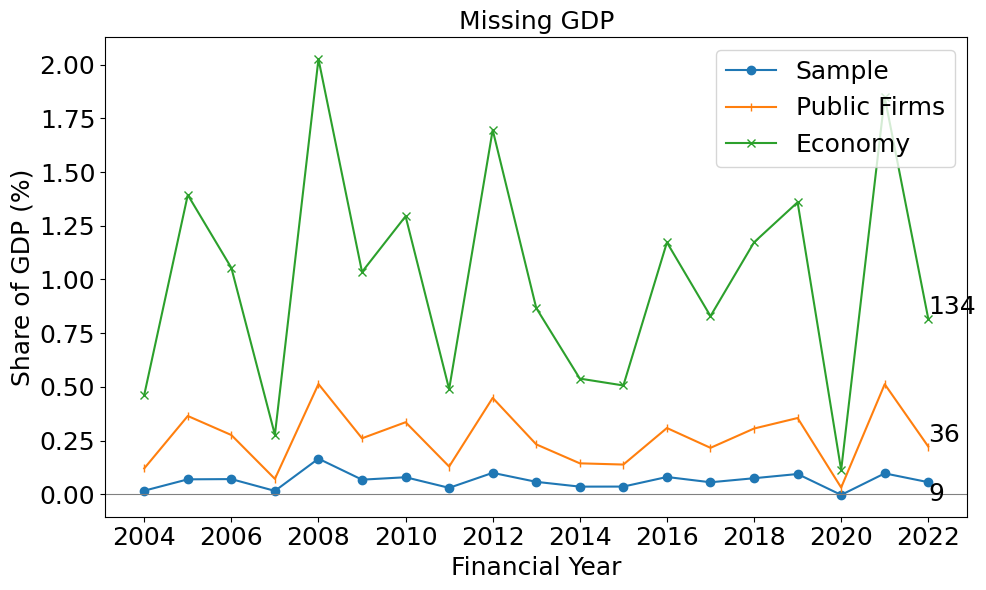

In [ ]:
def plot_output_with_text(df, var_list, lab_list, text_list, ylab, title, filename):
    # Ensure fyear is sorted and unique
    years = sorted(df['fyear'].unique())
    alternate_years = years[::2]  # Take every second year

    # Define a list of markers to cycle through
    markers = ['o', '|', 'x']

    # Set up the plot
    plt.figure(figsize=(10, 6))

    # Iterate over var_list, lab_list, and markers to make the plots
    for i, (var, lab) in enumerate(zip(var_list, lab_list)):
        # Use the modulo operator to cycle through markers
        marker = markers[i % len(markers)]
        plt.plot(df['fyear'], df[var], label=lab, marker=marker)

        # Add text for the last observation
        last_year = df['fyear'].iloc[-1]
        last_value = df[var].iloc[-1]
        if i>0:
            plt.text(last_year, last_value, text_list[i], fontsize=18, ha='left', va='bottom') # Added text annotation
        else:
            plt.text(last_year, last_value, text_list[i], fontsize=18, ha='left', va='top') # Added text annotation


    plt.axhline(0, color='grey', linewidth=0.8)

    # Add labels and title
    plt.xlabel('Financial Year', fontsize=18) # Increased font size
    plt.ylabel(ylab, fontsize=18) # Increased font size
    plt.title(title, fontsize=18) # Increased font size

    # Set alternate x-ticks and increase font size
    plt.xticks(alternate_years, fontsize=18)
    plt.yticks(fontsize=18) # Increased font size

    # Add legend and grid, and increase legend font size
    plt.legend(fontsize=18)
    plt.tight_layout()

    # Save the figure
    plt.savefig(f'{project_dir}/Output/Figures/{filename}', dpi=300)

    # Show the plot
    plt.show()

t1 = rgdp.loc[rgdp['fyear']==2022, 'missing_GDP_sample_total'].values[0]
t2 = rgdp.loc[rgdp['fyear']==2022, 'missing_GDP_total_pub'].values[0]
t3 = rgdp.loc[rgdp['fyear']==2022, 'missing_GDP_econ'].values[0]

rgdp_post_2003 = rgdp[rgdp['fyear']>2003]

plot_output_with_text(rgdp_post_2003, ['missing_GDP_sample_total_share', 'missing_GDP_total_pub_share', 'missing_GDP_econ_share'],
            ['Sample', 'Public Firms', 'Economy'], [f'{t1:.0f}', f'{t2:.0f}', f'{t3:.0f}'],
                      'Share of GDP (%)', 'Missing GDP', f'missing_GDP_share_using_val_per_emp_quintiles.png')

In [ ]:
df_emp['emp_pvt'] = df_emp['total_emp'] - df_emp['emp_pub']
df_pvt = df_emp.merge(val_data_per_emp, on='fyear', how='left')
df_pvt['missing_GDP_rest_of_econ'] = df_pvt['Q1'] * df_pvt['emp_pvt'] * 2/1e6
df_pvt['missing_GDP_econ'] = df_pvt['missing_GDP_total_pub'] + df_pvt['missing_GDP_rest_of_econ']
df_pvt

,fyear,total_emp,emp_pub,missing_GDP_total_pub,missing_GDP_econ,emp_pvt,Q1,Q2,Q3,Q4,Q5,missing_GDP_rest_of_econ
0,2003,137729,35643.8210,128.768174,NaN,102085.1790,NaN,NaN,NaN,NaN,NaN,NaN
1,2004,139240,36202.0635,13.829454,178.807215,103037.9365,800.568059,777.352882,691.525003,507.269106,0.000000,164.977762
2,2005,141710,37052.2020,43.377509,742.423551,104657.7980,3339.674901,953.812128,437.743738,216.664759,562.008541,699.046042
3,2006,144418,37774.1100,33.733317,750.912045,106643.8900,3362.493286,1023.267314,58.453251,619.813817,331.769555,717.178728
4,2007,146050,37742.5195,8.926111,654.504708,108307.4805,2980.304753,1231.644541,624.915678,161.895358,-77.373583,645.578598
5,2008,145373,36821.6479,64.114847,1206.806840,108551.3521,5263.370611,1464.281205,1108.727352,955.692831,684.471634,1142.691993
6,2009,139894,35212.0405,31.712331,712.511351,104681.9595,3251.749506,1523.833570,96.191754,187.744551,397.262106,680.799020
7,2010,139077,36029.5584,41.919730,716.555705,103047.4416,3273.424182,1085.539075,351.793729,640.385894,495.864780,674.635974
8,2011,139885,36912.5091,16.393224,472.574312,102972.4909,2215.062898,843.714821,728.602667,166.575848,112.789215,456.181088
9,2012,142475,37689.4689,58.269905,518.248512,104785.5311,2194.857454,1144.227760,980.799126,343.991537,780.006260,459.978608


In [ ]:
rgdp = pd.read_csv(f'{project_dir}/Data/GDPC1.csv')
rgdp['observation_date'] = pd.to_datetime(rgdp['observation_date'])  # Ensure CPI dataset is also in datetime format
rgdp['fyear'] = rgdp['observation_date'].dt.year
rgdp = rgdp.merge(sample_mgdp[['fyear', 'missing_GDP_sample_total']], on='fyear', how='inner')
rgdp = rgdp.merge(pub_mgdp[['fyear', 'missing_GDP_total_pub']], on='fyear', how='inner')
#rgdp = rgdp.merge(df_emp[['fyear', 'missing_GDP_econ']], on='fyear', how='inner')
rgdp = rgdp.merge(df_pvt[['fyear', 'missing_GDP_rest_of_econ', 'missing_GDP_econ']], on='fyear', how='inner')

# Get CPI numbers
cpi_data = pd.read_csv(f'{project_dir}/Data/CPIAUCSL.csv')
cpi_data['observation_date'] = pd.to_datetime(cpi_data['observation_date'])  # Ensure CPI dataset is also in datetime format
cpi_dec_2002 = cpi_data.loc[cpi_data['observation_date'] == '2002-12-01', 'CPIAUCSL'].values[0]
cpi_jun_2017 = cpi_data.loc[cpi_data['observation_date'] == '2017-06-01', 'CPIAUCSL'].values[0]

for col in ['missing_GDP_sample_total', 'missing_GDP_total_pub', 'missing_GDP_econ']:
    rgdp[col + '_Jun2017'] = rgdp[col] * cpi_jun_2017 / cpi_dec_2002
    rgdp[col + '_share'] = rgdp[col + '_Jun2017']/rgdp['GDPC1'] * 100

rgdp

,observation_date,GDPC1,fyear,missing_GDP_sample_total,missing_GDP_total_pub,missing_GDP_rest_of_econ,missing_GDP_econ,missing_GDP_sample_total_Jun2017,missing_GDP_sample_total_share,missing_GDP_total_pub_Jun2017,missing_GDP_total_pub_share,missing_GDP_econ_Jun2017,missing_GDP_econ_share
0,2003-01-01,14877.313,2003,8.853344,128.768174,NaN,NaN,11.890313,0.079922,172.939624,1.162439,NaN,NaN
1,2004-01-01,15449.757,2004,1.897596,13.829454,164.977762,178.807215,2.548530,0.016496,18.573382,0.120218,240.143598,1.554352
2,2005-01-01,15987.958,2005,8.265507,43.377509,699.046042,742.423551,11.100830,0.069432,58.257331,0.364383,997.097698,6.236554
3,2006-01-01,16433.148,2006,8.633627,33.733317,717.178728,750.912045,11.595228,0.070560,45.304884,0.275692,1008.498007,6.136974
4,2007-01-01,16762.446,2007,1.943199,8.926111,645.578598,654.504708,2.609776,0.015569,11.988042,0.071517,879.019984,5.243984
5,2008-01-01,16781.485,2008,20.692480,64.114847,1142.691993,1206.806840,27.790638,0.165603,86.108214,0.513114,1620.778759,9.658137
6,2009-01-01,16349.111,2009,8.259112,31.712331,680.799020,712.511351,11.092242,0.067846,42.590638,0.260507,956.924692,5.853069
7,2010-01-01,16789.751,2010,9.897343,41.919730,674.635974,716.555705,13.292437,0.079170,56.299489,0.335321,962.356384,5.731809
8,2011-01-01,17052.411,2011,3.779220,16.393224,456.181088,472.574312,5.075609,0.029765,22.016605,0.129111,634.681858,3.721948
9,2012-01-01,17442.759,2012,12.941413,58.269905,459.978608,518.248512,17.380716,0.099644,78.258277,0.448658,696.023716,3.990330


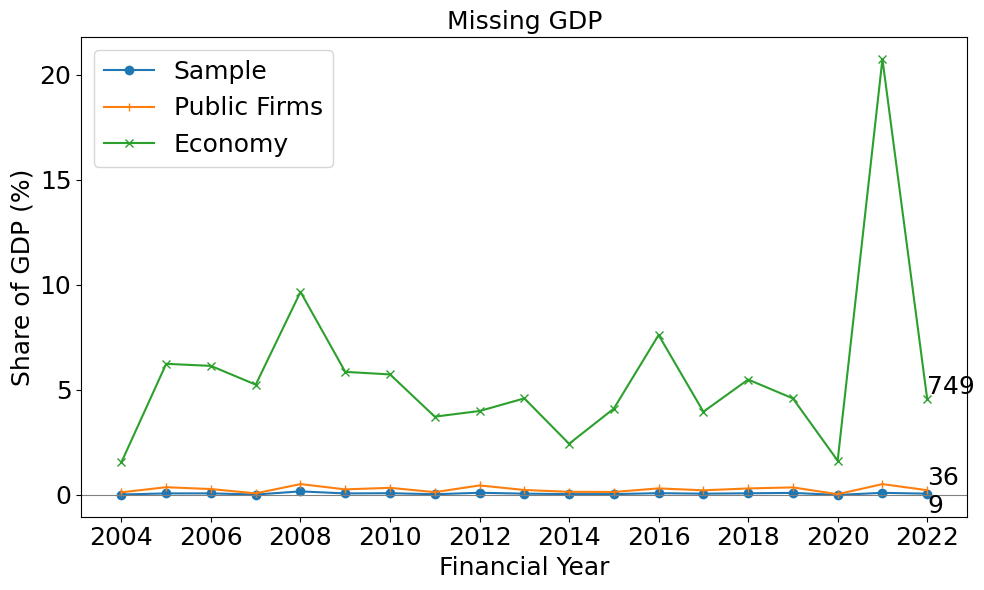

In [ ]:
t1 = rgdp.loc[rgdp['fyear']==2022, 'missing_GDP_sample_total'].values[0]
t2 = rgdp.loc[rgdp['fyear']==2022, 'missing_GDP_total_pub'].values[0]
t3 = rgdp.loc[rgdp['fyear']==2022, 'missing_GDP_econ'].values[0]

rgdp_post_2003 = rgdp[rgdp['fyear']>2003]

plot_output_with_text(rgdp_post_2003, ['missing_GDP_sample_total_share', 'missing_GDP_total_pub_share', 'missing_GDP_econ_share'],
            ['Sample', 'Public Firms', 'Economy'], [f'{t1:.0f}', f'{t2:.0f}', f'{t3:.0f}'],
                      'Share of GDP (%)', 'Missing GDP', f'missing_GDP_share_with_q1_as_pvt.png')

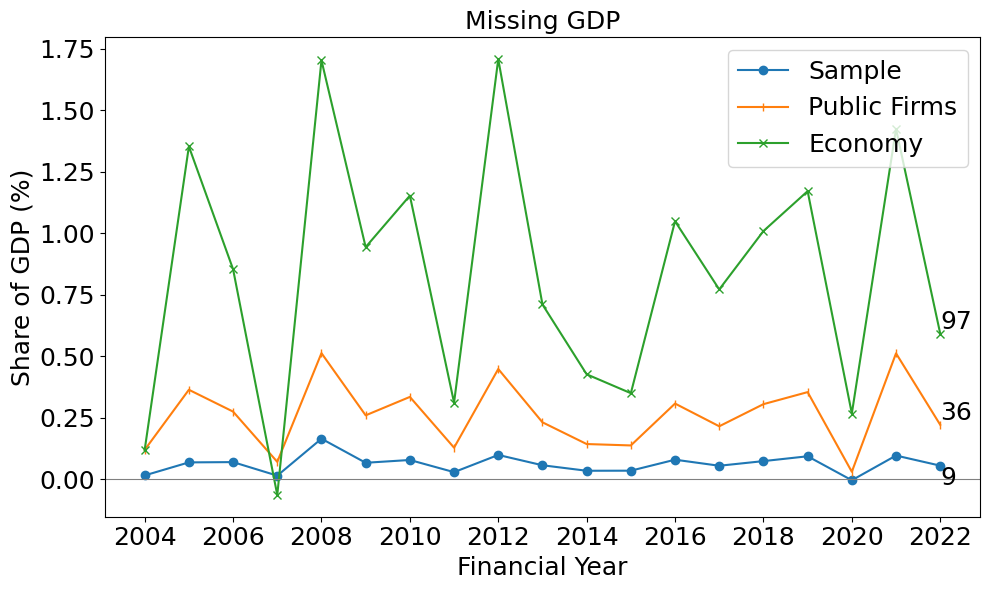

In [ ]:
df_emp['emp_pvt'] = df_emp['total_emp'] - df_emp['emp_pub']
df_pvt = df_emp.merge(val_data_per_emp, on='fyear', how='left')
df_pvt['missing_GDP_rest_of_econ'] = df_pvt['Q5'] * df_pvt['emp_pvt'] * 2/1e6
df_pvt['missing_GDP_econ'] = df_pvt['missing_GDP_total_pub'] + df_pvt['missing_GDP_rest_of_econ']

rgdp = pd.read_csv(f'{project_dir}/Data/GDPC1.csv')
rgdp['observation_date'] = pd.to_datetime(rgdp['observation_date'])  # Ensure CPI dataset is also in datetime format
rgdp['fyear'] = rgdp['observation_date'].dt.year
rgdp = rgdp.merge(sample_mgdp[['fyear', 'missing_GDP_sample_total']], on='fyear', how='inner')
rgdp = rgdp.merge(pub_mgdp[['fyear', 'missing_GDP_total_pub']], on='fyear', how='inner')
#rgdp = rgdp.merge(df_emp[['fyear', 'missing_GDP_econ']], on='fyear', how='inner')
rgdp = rgdp.merge(df_pvt[['fyear', 'missing_GDP_rest_of_econ', 'missing_GDP_econ']], on='fyear', how='inner')

# Get CPI numbers
cpi_data = pd.read_csv(f'{project_dir}/Data/CPIAUCSL.csv')
cpi_data['observation_date'] = pd.to_datetime(cpi_data['observation_date'])  # Ensure CPI dataset is also in datetime format
cpi_dec_2002 = cpi_data.loc[cpi_data['observation_date'] == '2002-12-01', 'CPIAUCSL'].values[0]
cpi_jun_2017 = cpi_data.loc[cpi_data['observation_date'] == '2017-06-01', 'CPIAUCSL'].values[0]

for col in ['missing_GDP_sample_total', 'missing_GDP_total_pub', 'missing_GDP_econ']:
    rgdp[col + '_Jun2017'] = rgdp[col] * cpi_jun_2017 / cpi_dec_2002
    rgdp[col + '_share'] = rgdp[col + '_Jun2017']/rgdp['GDPC1'] * 100

t1 = rgdp.loc[rgdp['fyear']==2022, 'missing_GDP_sample_total'].values[0]
t2 = rgdp.loc[rgdp['fyear']==2022, 'missing_GDP_total_pub'].values[0]
t3 = rgdp.loc[rgdp['fyear']==2022, 'missing_GDP_econ'].values[0]

rgdp_post_2003 = rgdp[rgdp['fyear']>2003]

plot_output_with_text(rgdp_post_2003, ['missing_GDP_sample_total_share', 'missing_GDP_total_pub_share', 'missing_GDP_econ_share'],
            ['Sample', 'Public Firms', 'Economy'], [f'{t1:.0f}', f'{t2:.0f}', f'{t3:.0f}'],
                      'Share of GDP (%)', 'Missing GDP', f'missing_GDP_share_with_q5_as_pvt.png')